Chi = 68.16117611726253
L = 3.174145883052277e+32


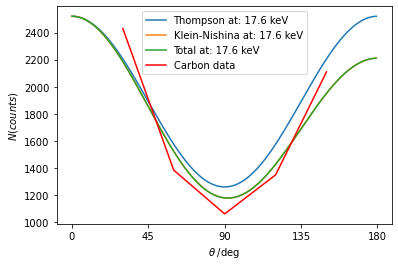

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.optimize as opt
from scipy.optimize import minimize, least_squares
from scipy.constants import e, h, hbar, alpha, c, m_e
DPI = 100

# A bunch of constants factored into a single variable. This is half the classical electron radius
f = (hbar * alpha / m_e / c)**2 / 2
# A grid of scattering angles in rad.
theta = np.arange(0, 2*np.pi, 0.01)
n = len(theta)
# Our grid of photon energies (in MeV).
Egrid = 0.0176
# scaling factor
L = 3.3e32
# factor to take degrees to radians because its stupid
a = np.pi/180

CoWeight = 0
InCoWeight = 1


# plot experimental data
x = [] # thetas
y = [] # counts
z = [] # errors

with open('Plexiglass2.csv') as File:  
    Line_reader = csv.reader(File, delimiter=',')
    for row in Line_reader:
        x.append(float(row[0]))
        y.append(float(row[3]))
        z.append(float(row[4]))
        
# define functions for the KN and R cross-sections as a function of scattering angle phi
def KleinNishina(phi):
    nu = Egrid * 1.e6 * e / h
    lam = c / nu
    lamp = lam + h / m_e / c * (1 - np.cos(phi*a))
    P = lam / lamp
    dsigma_dOmegaKN = f * P**2 * (P + 1/P - np.sin(phi*a)**2)
    return dsigma_dOmegaKN

def Rayleigh(phi):
    dsigma_dOmegaR = f * (1 + np.cos(phi*a)**2)
    return dsigma_dOmegaR
    
#write function to compute chi-squared as a function of a scaling factor l
def chi(l):
    chiSquare = 0
    for i,b in enumerate(x):
        chiSquare = chiSquare + (l * (InCoWeight*KleinNishina(b) + CoWeight*Rayleigh(b)) - y[i])**2 / z[i]**2
    #print(chiSquare)
    return chiSquare




result = opt.minimize_scalar(chi, bounds=(3e30,4e34),method='bounded')
print("Chi = " + str(result.fun))
print("L = " + str(result.x))

def plot_diff_xsec(E):
    """Plot the differential cross section for incoming photon energy, E."""

    # Incoming photon frequency (s^-1) and wavelength (m).
    nu = E * 1.e6 * e / h
    lam = c / nu
    # energy in keV
    Ek = E*10**3

    # Scattered photon wavelength (m).
    lamp = lam + h / m_e / c * (1 - np.cos(theta))
    P = lam / lamp
    # Differential cross section given by the Klein-Nishina formula.
    dsigma_dOmegaKN = f * P**2 * (P + 1/P - np.sin(theta)**2)
    dsigma_dOmegaT = f * (1 + np.cos(theta)**2)

    # Plot Thompson.
    ax2.plot(np.degrees(theta[:n // 2]), result.x * dsigma_dOmegaT[:n // 2],
             label= 'Thompson at: ' + str(Ek) + r' keV')
    # Plot Klein-Nishina
    ax2.plot(np.degrees(theta[:n//2]), result.x * dsigma_dOmegaKN[:n//2],
             label='Klein-Nishina at: ' + str(Ek) + r' keV')
    # Plot the total csection
    ax2.plot(np.degrees(theta[:n//2]), result.x * (InCoWeight*dsigma_dOmegaKN[:n//2] + CoWeight*dsigma_dOmegaT[:n // 2]), 
             label='Total at: ' + str(Ek) + r' keV')

# A Matplotlib figure with a polar Axes above a Cartesian one.
fig, ax2 = plt.subplots()

plot_diff_xsec(Egrid)
ax2.set_xlabel(r'$\theta\;/\mathrm{deg}$')
ax2.set_ylabel(r'$N (counts)$')
# Set the Cartesian x-axis ticks to sensible values (in degrees).
ax2.set_xticks([0, 45, 90, 135, 180])

# plot experimental data

        
plt.plot(x,y,color='r',label="Carbon data")

plt.legend()
plt.show()


